In [3]:
# Input data
import scipy.io as spio
import numpy as np
from utilities import *
from sklearn.model_selection import train_test_split

In [4]:
# test and train
X_train_all, Y_train_all, list_ch_train = read_data(data_path="../data/har-data/", split="train") # train
X_test, Y_test, list_ch_test = read_data(data_path="../data/har-data/", split="test") # test
assert list_ch_train == list_ch_test, "Mistmatch in channels!"

# Normalize
X_train_all_norm, X_test_norm = standardize(train=X_train_all, test=X_test)

# Validationset
X_train_norm, X_valid_norm, Y_train, Y_valid = train_test_split(X_train_all_norm, Y_train_all, 
                                                                stratify = Y_train_all,
                                                                random_state = 123, test_size=0.30)
print(X_train_norm.shape, X_valid_norm.shape, Y_train.shape, Y_valid.shape)
print(X_train_norm.dtype, X_valid_norm.dtype, Y_train.dtype, Y_valid.dtype)

(5146, 128, 9) (2206, 128, 9) (5146,) (2206,)
float64 float64 int64 int64


In [5]:
### Hyperparameters

# Input data
batch_size = X_train_norm.shape[0]// 10 # minibatch size & number of minibatches
seq_len = X_train_norm.shape[1] # Number of steps: each trial length
n_channels = X_train_norm.shape[2] # number of channels in each trial
print('batch_size, seq_len, n_channels', batch_size, seq_len, n_channels)

# Output labels
n_classes = int(Y_train_all.max(axis=0))
print('Y_train_all.max(axis=0):', Y_train_all.max(axis=0))
print('Y_test.max(axis=0):', Y_test.max(axis=0))

# learning parameters
learning_rate = 0.001 #1e-3
epochs = 100 # num iterations for updating model
keep_prob = 0.50 # 90% neurons are kept and 10% are dropped out

batch_size, seq_len, n_channels 514 128 9
Y_train_all.max(axis=0): 6
Y_test.max(axis=0): 6


In [6]:
Y_train_onehot = one_hot(labels=Y_train.reshape(-1), n_class=n_classes)
Y_valid_onehot = one_hot(labels=Y_valid.reshape(-1), n_class=n_classes)
Y_test_onehot = one_hot(labels=Y_test.reshape(-1), n_class=n_classes)

print(Y_train_onehot.shape, Y_valid_onehot.shape, Y_test_onehot.shape)
print(X_train_norm.shape, X_valid_norm.shape, X_test_norm.shape)

(5146, 6) (2206, 6) (2947, 6)
(5146, 128, 9) (2206, 128, 9) (2947, 128, 9)


In [7]:
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


In [8]:
#  Buffering/ placeholders to transfer the data from py to tf
inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs_')
labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels_')
keep_prob_ = tf.placeholder(tf.float32, name = 'keep_prob_')
learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate_')# Construct the LSTM inputs and LSTM cells

In [9]:
# with graph.as_default():
# (5146, 128, 9) (2206, 128, 9) (5146,) (2206,)
# (batch, 128, 9) --> (batch, 64, 18)
conv1 = tf.layers.conv1d(inputs=inputs_, filters=26, kernel_size=2, strides=1, padding='same', 
                         activation = tf.nn.relu)
max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')
# max_pool_1 = tf.nn.dropout(max_pool_1, keep_prob=keep_prob_)
print(conv1.shape, max_pool_1.shape)

# (batch, 64, 18) --> (batch, 32, 36)
conv2 = tf.layers.conv1d(inputs=max_pool_1, filters=36, kernel_size=2, strides=1, padding='same', 
                         activation = tf.nn.relu)
max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')
# max_pool_2 = tf.nn.dropout(max_pool_2, keep_prob=keep_prob_)
print(conv2.shape, max_pool_2.shape)

# (batch, 32, 36) --> (batch, 16, 72)
conv3 = tf.layers.conv1d(inputs=max_pool_2, filters=72, kernel_size=2, strides=1, padding='same', 
                         activation = tf.nn.relu)
max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=2, strides=2, padding='same')
# max_pool_3 = tf.nn.dropout(max_pool_3, keep_prob=keep_prob_)
print(conv3.shape, max_pool_3.shape)

# (batch, 16, 72) --> (batch, 8, 144)
conv4 = tf.layers.conv1d(inputs=max_pool_3, filters=144, kernel_size=2, strides=1, 
                         padding='same', activation = tf.nn.relu)
max_pool_4 = tf.layers.max_pooling1d(inputs=conv4, pool_size=2, strides=2, padding='same')
# max_pool_4 = tf.nn.dropout(max_pool_4, keep_prob=keep_prob_)
print(conv4.shape, max_pool_4.shape)

# Flatten and add dropout + predicted output
flat = tf.reshape(max_pool_4, (-1, 8*144))
flat = tf.nn.dropout(flat, keep_prob=keep_prob_)
logits = tf.layers.dense(flat, n_classes)

(?, 128, 26) (?, 64, 26)
(?, 64, 36) (?, 32, 36)
(?, 32, 72) (?, 16, 72)
(?, 16, 144) (?, 8, 144)


In [10]:
# Backward pass: error backpropagation
# Cost function
cost_tensor = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_)
cost = tf.reduce_mean(input_tensor=cost_tensor)

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
print(correct_pred, accuracy)

Tensor("Equal:0", shape=(?,), dtype=bool) Tensor("accuracy:0", shape=(), dtype=float32)


In [32]:
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

# Save the training result or trained and validated model params
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over batches
        for x, y in get_batches(X_train_norm, Y_train_onehot, batch_size):
            
            ######################## Training
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : keep_prob, learning_rate_ : learning_rate}
            
            # Loss
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            ################## Validation
            val_acc_ = []
            val_loss_ = []    
            for x_v, y_v in get_batches(X_valid_norm, Y_valid_onehot, batch_size):
                
                # Feed
                feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0}  

                # Loss
                loss_v, acc_v = sess.run([cost, accuracy], feed_dict = feed)                    
                val_acc_.append(acc_v)
                val_loss_.append(loss_v)

            # Store
            validation_acc.append(np.mean(val_acc_))
            validation_loss.append(np.mean(val_loss_))
            
        # Print info for every iter/epoch
        print("Epoch: {}/{}".format(e+1, epochs),
              "Train loss: {:6f}".format(np.mean(train_loss)),
              "Valid loss: {:.6f}".format(np.mean(validation_loss)),
              "Train acc: {:6f}".format(np.mean(train_acc)),
              "Valid acc: {:.6f}".format(np.mean(validation_acc)))
                
    saver.save(sess,"checkpoints-cnn/har.ckpt")

Epoch: 1/100 Train loss: 1.580470 Valid loss: 1.511572 Train acc: 0.258171 Valid acc: 0.305350
Epoch: 2/100 Train loss: 1.401583 Valid loss: 1.337553 Train acc: 0.367510 Valid acc: 0.433293
Epoch: 3/100 Train loss: 1.251326 Valid loss: 1.186711 Train acc: 0.478729 Valid acc: 0.551978
Epoch: 4/100 Train loss: 1.092378 Valid loss: 1.020455 Train acc: 0.562792 Valid acc: 0.632429
Epoch: 5/100 Train loss: 0.941493 Valid loss: 0.869896 Train acc: 0.627821 Valid acc: 0.688113
Epoch: 6/100 Train loss: 0.821550 Valid loss: 0.755217 Train acc: 0.676427 Valid acc: 0.728599
Epoch: 7/100 Train loss: 0.729315 Valid loss: 0.669332 Train acc: 0.713035 Valid acc: 0.758720
Epoch: 8/100 Train loss: 0.656900 Valid loss: 0.603011 Train acc: 0.741513 Valid acc: 0.781803
Epoch: 9/100 Train loss: 0.599155 Valid loss: 0.550369 Train acc: 0.764051 Valid acc: 0.800038
Epoch: 10/100 Train loss: 0.552246 Valid loss: 0.507701 Train acc: 0.782315 Valid acc: 0.814810
Epoch: 11/100 Train loss: 0.513422 Valid loss: 0.

Epoch: 87/100 Train loss: 0.118355 Valid loss: 0.124288 Train acc: 0.950939 Valid acc: 0.951063
Epoch: 88/100 Train loss: 0.117281 Valid loss: 0.123405 Train acc: 0.951397 Valid acc: 0.951427
Epoch: 89/100 Train loss: 0.116217 Valid loss: 0.122526 Train acc: 0.951845 Valid acc: 0.951793
Epoch: 90/100 Train loss: 0.115191 Valid loss: 0.121672 Train acc: 0.952274 Valid acc: 0.952150
Epoch: 91/100 Train loss: 0.114172 Valid loss: 0.120850 Train acc: 0.952704 Valid acc: 0.952498
Epoch: 92/100 Train loss: 0.113171 Valid loss: 0.120034 Train acc: 0.953123 Valid acc: 0.952844
Epoch: 93/100 Train loss: 0.112185 Valid loss: 0.119235 Train acc: 0.953548 Valid acc: 0.953183
Epoch: 94/100 Train loss: 0.111191 Valid loss: 0.118432 Train acc: 0.953978 Valid acc: 0.953530
Epoch: 95/100 Train loss: 0.110227 Valid loss: 0.117642 Train acc: 0.954395 Valid acc: 0.953865
Epoch: 96/100 Train loss: 0.109280 Valid loss: 0.116886 Train acc: 0.954803 Valid acc: 0.954182
Epoch: 97/100 Train loss: 0.108338 Valid

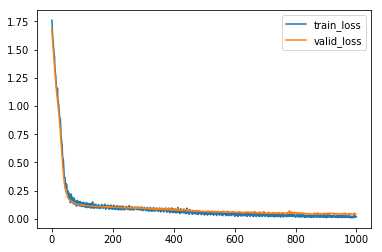

In [33]:
import matplotlib.pyplot as mplot

mplot.plot(train_loss, label='train_loss')
mplot.plot(validation_loss, label='valid_loss')
mplot.legend()
mplot.show()

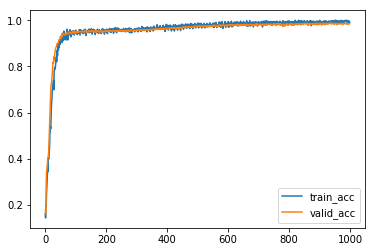

In [34]:
# import matplotlib.pyplot as mplot

mplot.plot(train_acc, label='train_acc')
mplot.plot(validation_acc, label='valid_acc')
mplot.legend()
mplot.show()

In [35]:
test_acc = []

with tf.Session() as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-cnn'))
    
    for x_t, y_t in get_batches(X_test_norm, Y_test_onehot, batch_size):
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1}
        
        batch_acc = sess.run(accuracy, feed_dict=feed)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints-cnn/har.ckpt
Test accuracy: 0.936187
